In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile as shp
from pyproj import Proj, transform
import cv2

In [64]:
#Create a blank image
blank_image = np.zeros((1080,1920,3), np.uint8) #Size of the image 1080 height, 1920 width, 3 channels of colour
blank_image[:, :] = [255, 255, 255] #Sets the color to white

In [65]:
#Draws circle ; center, radius, colour, -1 to fill the shape
cv2.circle(blank_image, (960, 540), 200, (0, 255, 0), -1)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [66]:
#write text
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(blank_image, 'zone_id', (960, 540), 
            font, 2, (255, 0, 0), 5, cv2.LINE_AA) 
  



array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

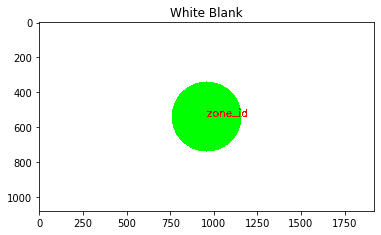

In [67]:
# to show the image inside the Jupyter notebook
plt.imshow(blank_image)
plt.title("White Blank")
plt.show()

In [ ]:
#to show the image outside the notebook
cv2.imshow("White Blank", blank_image) 

In [9]:
shp_path = "/Users/acoullandreau/Desktop/Taxi_rides_DS/taxi_zones/taxi_zones.shp"
sf_nyc = shp.Reader(shp_path)

In [169]:
def convert_projection(x, y, projection, inverse=False):
    """
    This function converts coordinates from one projection system to another.
    We used in particular EPSG 2263 (Lambert Conformal Conis) and the image pixels size.
    
    Input: x an y coordinates to convert, as well as the "direction" of 
    the projection (i.e whether we want to project from EPSG2263 to the image scale (inverse = False), 
    or the inverse (inverse = True).
    
    Output: the x and y coordinates in the new coordinate system.
    """
    
    x_min = projection[0]
    y_min = projection[1]
    conversion = projection[2]
    
    #to be able to center the image, we first translate the coordinates to the origin
    x = (x - x_min) *conversion
    y = (y - y_min) *conversion
    
    return x, y


def define_projection(max_bound, min_bound):
    #We get the max 'coordinates' for both the target image and the shape we want to draw
    image_x_max = 1920
    image_y_max = 1080
    shape_x_max = max_bound[0]
    shape_y_max = max_bound[1]
    shape_x_min = min_bound[0]
    shape_y_min = min_bound[1]
    
    if (shape_x_max - shape_x_min)/image_x_max > (shape_y_max - shape_y_min)/image_y_max:
        conversion = image_x_max / (shape_x_max - shape_x_min)
        axis_to_center = 'y'
    else:
        conversion = image_y_max / (shape_y_max - shape_y_min)
        axis_to_center = 'x'

    return shape_x_min, shape_y_min, conversion, axis_to_center


def find_max_coords(shape_dict):
    x_max = -99999999
    x_min = 99999999
    y_max = -99999999
    y_min = 99999999
    
    for zone in shape_dict:
        zone_shape = shape_dict[zone]
        max_bound_zone = zone_shape[3]
        min_bound_zone = zone_shape[4]
        if max_bound_zone[0] > x_max:
            x_max = max_bound_zone[0]
        if max_bound_zone[1] > y_max:
            y_max = max_bound_zone[1]
        if min_bound_zone[0] < x_min:
            x_min = min_bound_zone[0]
        if min_bound_zone[1] < y_min:
            y_min = min_bound_zone[1]  
    
    max_bound = (x_max, y_max)
    min_bound = (x_min, y_min)
    
    return max_bound, min_bound

In [11]:
def shp_to_df(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    
    return df

def convert_point(coords):
    
    return (coords[0], coords[1])


def calculate_centroid(points):
    x_sum = 0
    y_sum = 0
    for coords in points:
        x_sum += coords[0]
        y_sum += coords[1]
        
    x_mean = x_sum/len(points)
    y_mean = y_sum/len(points)
    
    return x_mean, y_mean


def calculate_boundaries(points):
    x_max = -99999999
    x_min = 99999999
    y_max = -99999999
    y_min = 99999999
    
    for coords in points:
        if coords[0] > x_max:
            x_max = coords[0]
        if coords[0] < x_min:
            x_min = coords[0]
        if coords[1] > y_max:
            y_max = coords[1]
        if coords[1] < y_min:
            y_min = coords[1]
        
    max_bound = (x_max, y_max)
    min_bound = (x_min, y_min)
    
    return max_bound, min_bound



def process_shape_boundaries(df_sf, sf):
    """
    This function builds a dictionary with the shape boundaries coordinates, converted,
    for each zone id available in the shape file. 

    Input: shapefile and dataframe converted from the shapefile
    
    Output: a dictionary with for each zone id the set of boundary coordinates in WGS84.
    """
    
    shape_dict = {}
    index_list = df_sf.index.tolist()
    
    for zone_id in index_list:
        #for each zone id available in the shapefile
        if zone_id not in shape_dict:
            #we only process the coordinates if it is not yet included in the dictionary
            shape_zone = sf.shape(zone_id)
            
            points = [convert_point(i) for i in shape_zone.points]
            
            x_center, y_center = calculate_centroid(points)
            max_bound, min_bound = calculate_boundaries(points)
            
            #we add to the dictionary, for the zone id, the shape boundaries as well
            #as the coordinates of the center of the shape
            shape_dict[zone_id]=(points, x_center, y_center, max_bound, min_bound)

    return shape_dict  

In [162]:
def convert_shape_boundaries(shape_dict, projection):
    """
    This function edits the dictionary with the shape boundaries coordinates by converting
    them to the image scale 'coordinate' system.  

    Input: shape boundaries dictionary
    
    Output: a dictionary with for each zone id the set of boundary coordinates 
    in the image scale.
    """
    
    converted_dict = {}
    axis_to_center = projection[3]
    
    for zone_id in shape_dict:
        curr_shape = shape_dict[zone_id]
        
        points = curr_shape[0]
        x_center = curr_shape[1]
        y_center = curr_shape[2]
        max_bound = curr_shape[3]
        min_bound = curr_shape[4]
        
        converted_points = []
        for point in points:
            converted_point = [0, 0] 
            converted_point[0], converted_point[1] = convert_projection(point[0], point[1], projection)
            converted_point[1] = 1080 - converted_point[1]
            converted_points.append(converted_point)
        
        x_center, y_center = convert_projection(x_center, y_center, projection)
        max_bound = (convert_projection(max_bound[0], max_bound[1], projection))
        min_bound = (convert_projection(min_bound[0], min_bound[1], projection))
        
        
        #We edit the dictionary
        converted_dict[zone_id]=(converted_points, x_center, y_center, max_bound, min_bound)
        
    return converted_dict  

In [13]:
df_sf = shp_to_df(sf_nyc)
shape_dict = process_shape_boundaries(df_sf, sf_nyc)

In [14]:
shape_boundaries = process_shape_boundaries(df_sf, sf_nyc)

In [141]:
max_bound, min_bound = find_max_coords(shape_boundaries)
shape_x_min, shape_y_min, conversion, axis_to_center = define_projection(max_bound, min_bound)

In [142]:
print(max_bound)

(1067382.508405164, 272844.2940054685)


In [143]:
print(conversion)

0.007071653600444159


In [163]:
projection = (shape_x_min, shape_y_min, conversion, axis_to_center)
new_dict = convert_shape_boundaries(shape_boundaries, projection)

In [145]:
shape_boundaries[0]

([(933100.9183527103, 192536.08569720192),
  (933091.0114800561, 192572.17526147654),
  (933088.5848363293, 192604.9701013019),
  (933121.5604029286, 192857.3815947791),
  (933149.268070866, 192978.64529974),
  (933222.303599316, 193293.27321561542),
  (933252.5816221443, 193450.60036714407),
  (933297.7228000937, 193555.43279791903),
  (933330.5712151835, 193748.8233831425),
  (933350.6320882778, 193794.68697530977),
  (933355.7056937596, 193834.0240346551),
  (933365.7979032588, 193886.46647872418),
  (933431.7392324115, 194391.29051182547),
  (933465.0379729305, 194801.09275264665),
  (933463.4338186719, 195227.36293221635),
  (933471.1052103372, 195315.8792411817),
  (933483.7536692393, 195397.82719968376),
  (933511.4361339996, 195509.2545406304),
  (933554.0907006934, 195620.65066105462),
  (933609.1944352826, 195718.9049942211),
  (933669.2474974946, 195797.47528837126),
  (933731.7750771455, 195866.2036557206),
  (933779.2756322531, 195908.73159505273),
  (933841.7617821106, 19

In [146]:
new_dict[0]

([(140.9084213885992, 512.0881695716273),
  (140.83836341692486, 512.3433824687684),
  (140.8212030330775, 512.5752962158954),
  (141.05439481734604, 514.3602628625367),
  (141.25033384707535, 515.2177977783267),
  (141.76681580479942, 517.4427374124275),
  (141.98093149394734, 518.5553005299827),
  (142.30015426752138, 519.2966391665157),
  (142.53244688035983, 520.6642303948033),
  (142.67431042580563, 520.9885618314822),
  (142.71018920627802, 521.2667398888325),
  (142.78155781591957, 521.6375946872497),
  (143.24787205364015, 525.2075353785212),
  (143.48334921192142, 528.1055148702944),
  (143.4720051886828, 531.1199499204105),
  (143.5262546131735, 531.7459065954034),
  (143.61570013310893, 532.3254141711934),
  (143.8114609347, 533.1133897279867),
  (144.11309925483573, 533.9011445040601),
  (144.50277377794123, 534.5959651129562),
  (144.9274482315501, 535.151587016471),
  (145.36962161531602, 535.6376102228896),
  (145.7055290868658, 535.9383530781871),
  (146.1474094934828, 

In [164]:
new_max_bound, new_min_bound = find_max_coords(new_dict)

In [165]:
new_max_bound

(1090.501311156399, 1080.0)

In [166]:
new_min_bound

(0.0, 0.0)

In [112]:
max_x

41.85406981149304

In [113]:
max_y

0

In [ ]:
points = 

In [167]:
import cv2
import numpy as np

blank_image = np.zeros((1080,1920,3), np.uint8) #Size of the image 1080 height, 1920 width, 3 channels of colour
blank_image[:, :] = [255, 255, 255] #Sets the color to white

for item in new_dict:
    shape = new_dict[item]
    pts = np.array(shape[0], np.int32)
    cv2.polylines(blank_image, [pts], True, (0, 0, 0), 3)

cv2.imshow('image',blank_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
for item in new_dict

contour = np.array(new_collection[0]).reshape((-1,1,2)).astype(np.int32)
cv2.drawContours(blank_image_2,[contour],0,(0,0,0),1)

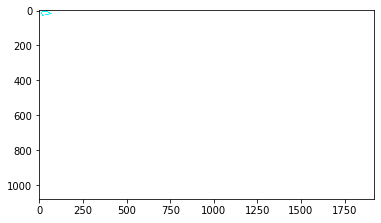

In [252]:
plt.imshow(blank_image)
#plt.title("Test")
#plt.axis('off')
plt.show()
